# Get steps (and other features) from epochs.csv

In [1]:
# imports
import pandas as pd
import pickle

In [2]:
# load dataset
df = pd.read_csv('data/epochs.csv')
print(f'num of examples: {df.shape[0]}\nnum of categories: {df.shape[1]}')
df.head()

num of examples: 2119020
num of categories: 15


,userId,userAccessToken,summaryId,activityType,activeKilocalories,steps,distanceInMeters,durationInSeconds,activeTimeInSeconds,startTimeInSeconds,startTimeOffsetInSeconds,met,intensity,meanMotionIntensity,maxMotionIntensity
0,e31d5fa7-7a63-43a6-973a-f2169c0661f7,69420bd2-052d-4df2-9ba1-55d9b2fd7489,sd46aeb3d-626066e3-6,WALKING,93,1506,125.73,900.0,860,1650484963,-18000,11.544035,HIGHLY_ACTIVE,2.411726,4.152604
1,e31d5fa7-7a63-43a6-973a-f2169c0661f7,69420bd2-052d-4df2-9ba1-55d9b2fd7489,sd46aeb3d-62606a67-6,WALKING,3,1174,207.00,900.0,584,1650485863,-18000,42.362816,HIGHLY_ACTIVE,3.986872,5.518433
2,e31d5fa7-7a63-43a6-973a-f2169c0661f7,69420bd2-052d-4df2-9ba1-55d9b2fd7489,sd46aeb3d-62606a67-8,SEDENTARY,0,0,0.00,900.0,143,1650485863,-18000,1.000000,SEDENTARY,0.000000,0.000000
3,e31d5fa7-7a63-43a6-973a-f2169c0661f7,69420bd2-052d-4df2-9ba1-55d9b2fd7489,sd46aeb3d-62606deb-6,WALKING,41,1363,222.45,900.0,188,1650486763,-18000,44.880870,HIGHLY_ACTIVE,3.548326,3.323441
4,e31d5fa7-7a63-43a6-973a-f2169c0661f7,69420bd2-052d-4df2-9ba1-55d9b2fd7489,sd46aeb3d-6260716f-6,WALKING,73,1755,461.11,900.0,269,1650487663,-18000,6.175430,HIGHLY_ACTIVE,5.397980,6.647376


In [3]:
users = df['userId'].unique()
print(f'num of users: {len(users)}')

num of users: 213


In [37]:
users_weekly_epoch = {}

## Data Preprocessing 

*startTimeOffsetInSeconds* is the offset in seconds to add to startTimeInSeconds to derive the "local" time of the device that captured the data, Garmin manual page 23. Because the measurements were taken in Israel, we expect the offsets to be +7200 (UTC +2) or +10800 (UTC +3) seconds. About 10 percent of the data had unusual offsets, which we decided to remove.

In [5]:
df = df[df['startTimeOffsetInSeconds'].isin([7200, 10800])]

*startTimeInSeconds* is in unix format. we want to convert it to utc format, taking into account the offset to get the local time.

In [6]:
df['startTimeLocal'] = pd.to_datetime(df['startTimeInSeconds'] + df['startTimeOffsetInSeconds'], unit='s')
df = df.drop('startTimeInSeconds', axis=1)
df = df.drop('startTimeOffsetInSeconds', axis=1)

add *WeekNumber* for each example

In [7]:
# returns the week number (1,52) of the date.
# assuming week starts on a sunday, and not a monday.
def get_week_number(date):
    adjusted_date = date - pd.Timedelta(days=(date.weekday() + 1) % 7) # date of closest, prev sunday
    return adjusted_date.isocalendar()[1]

In [8]:
df['WeekNumber'] = df['startTimeLocal'].apply(get_week_number)

## Extracting steps data 

```python
users_weekly_epoch = {
    userID: {
        week_number: pd.DataFrame(startTimeLocal, steps, userId, activeTimeInSeconds, distanceInMeters, speed, is_running)
    }
}

| Level               | Description                                       |
|---------------------|---------------------------------------------------|
| `users_weekly_epoch`| The main dictionary containing all users' data.   |
| `userID`            | A unique identifier for each soldier.                |
| `week_number`       | A key within each `userID` dictionary representing a specific week. |
| `pd.DataFrame`      | A dataframe filled with the relevant data for that user and week. Split by 15 min intervals.|

Each dataframe contains the following data:

- `startTimeLocal` - local time of user, example: 2022-08-28 19:15:00
- `steps` - number of steps in the 15 minute interval 
- `userId` - soldier's ID
- `activeTimeInSeconds` - number of seconds the user was active in the 15 minute interval. i.e. not sedentary
- `distanceInMeters` - distance travelled by soldier in the 15 minute interval
- `speed` - average speed of soldier in 15 minute interval in km/h, of when he was walking/running. 
- `is_running` - True if soldier was running (speed >= 7.5 km/h) in the 15 minute interval, False o.w.

In [9]:
agg_dict = {
    'steps': 'sum',
    'userId': 'first',  
    'activeTimeInSeconds': 'sum', 
    'distanceInMeters': 'sum'
}

In [52]:
for user, user_df in df.groupby('userId'):
    weekly_user_df = {}
    for week_num, week_df in user_df.groupby('WeekNumber'):
        weekly_df = week_df.groupby('startTimeLocal').agg(agg_dict).reset_index()
        # speed:
        filtered_df = week_df[week_df['activityType'].isin(['WALKING', 'RUNNING'])]
        grouped_df = filtered_df.groupby('startTimeLocal').agg({'activeTimeInSeconds':'sum','distanceInMeters':'sum'}).reset_index()
        grouped_df['speed'] = (grouped_df['distanceInMeters'] / grouped_df['activeTimeInSeconds']) * 3.6 # convert from m/s to km/h
        weekly_df = weekly_df.merge(grouped_df[['startTimeLocal', 'speed']], on='startTimeLocal', how='left')
        weekly_df['speed'] = weekly_df['speed'].fillna(0)
        weekly_df['is_running'] = weekly_df['speed'] >= 7.5
        
        weekly_user_df[week_num] = weekly_df
    
    users_weekly_epoch[user] = weekly_user_df

save to a pickle

In [54]:
pickle_file_path = 'steps.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(users_weekly_epoch, file)

In [20]:
og_user = '00a7a796-c572-44d7-a950-7f6bca4a4394'

In [21]:
# TODO: delete
users_weekly_epoch.keys()

dict_keys(['00a7a796-c572-44d7-a950-7f6bca4a4394', '02a9bd9f-430e-4351-b1e7-9ae10b9413a3', '03406515-0b5e-4a5a-9ff1-a85c06513e60', '042e1305-faa2-4eb8-a833-d2181efdeb31', '050b5881-43e2-44c8-8964-148576d30359', '0793ab56-25e1-4b0b-9a9b-be573b682523', '091855dd-6b30-4e37-818d-6341a853d026', '091b0864-139b-41ce-b365-11831889a3c7', '0c80b148-0d19-4a71-9309-b86f1ab9f3ce', '0d31cc9d-31ea-4473-b513-3f477a73e708', '0e79fdf3-6791-4c56-88ce-fe56f722a99e', '0f777005-330d-4d68-8960-9fe8f0501e3d', '0fa9bebd-47a8-4979-9ae4-54f8288dc150', '0fc41759-3017-42f4-b784-69f90f913954', '102d37b9-87fa-40cc-92ff-c88b9d7b2311', '1256e510-9559-47ff-8389-f76287ae974e', '1667c01c-6bf8-4983-b946-d174ae40e539', '16dfee60-03fa-4d81-982a-1ebaf812b3c5', '176d1f17-4353-4eb6-9543-6a645ff5bfd1', '184a8b74-e4ef-4f13-8759-c6fef09a5888', '1c4310c0-a707-4565-abba-cc948d0dd3e0', '207af7e1-9b5b-4296-a7fa-96b6d7f56339', '21b2fcc0-43aa-4160-9db3-2d57970266ec', '27ec307b-918c-4c9b-a3fa-157941b816f1', '29f6135a-5e81-4cde-92d6-4cfe

In [53]:
num_of_running = 0
num_of_walking = 0

for user in users_weekly_epoch.keys():
    d = users_weekly_epoch[user]
    for week in d.keys():
        w_df = d[week]
        running_count = w_df['is_running'].sum()
        walking_count = len(w_df) - running_count
        num_of_running += running_count
        num_of_walking += walking_count

print("num of walking entries:",num_of_walking)
print("num of running entries:", num_of_running)


num of walking entries: 1362995
num of running entries: 4263


In [13]:
users_weekly_epoch[og_user].keys()

dict_keys([4, 5, 35, 36, 45, 50, 51])

In [40]:
test_df = users_weekly_epoch[og_user][35]
test_df

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running
0,2022-09-04 09:15:00,49,00a7a796-c572-44d7-a950-7f6bca4a4394,600,40.79,1.147219,False
1,2022-09-04 09:30:00,103,00a7a796-c572-44d7-a950-7f6bca4a4394,900,85.76,1.715200,False
2,2022-09-04 09:45:00,29,00a7a796-c572-44d7-a950-7f6bca4a4394,900,24.15,1.449000,False
3,2022-09-04 10:00:00,172,00a7a796-c572-44d7-a950-7f6bca4a4394,900,259.72,3.087240,False
4,2022-09-04 10:15:00,169,00a7a796-c572-44d7-a950-7f6bca4a4394,900,203.43,1.743000,False
...,...,...,...,...,...,...,...
264,2022-09-07 03:15:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
265,2022-09-07 03:30:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
266,2022-09-07 03:45:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
267,2022-09-07 04:00:00,64,00a7a796-c572-44d7-a950-7f6bca4a4394,900,53.29,1.065800,False


In [45]:
above_threshold = test_df[test_df['speed'] > 5]
above_threshold

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running


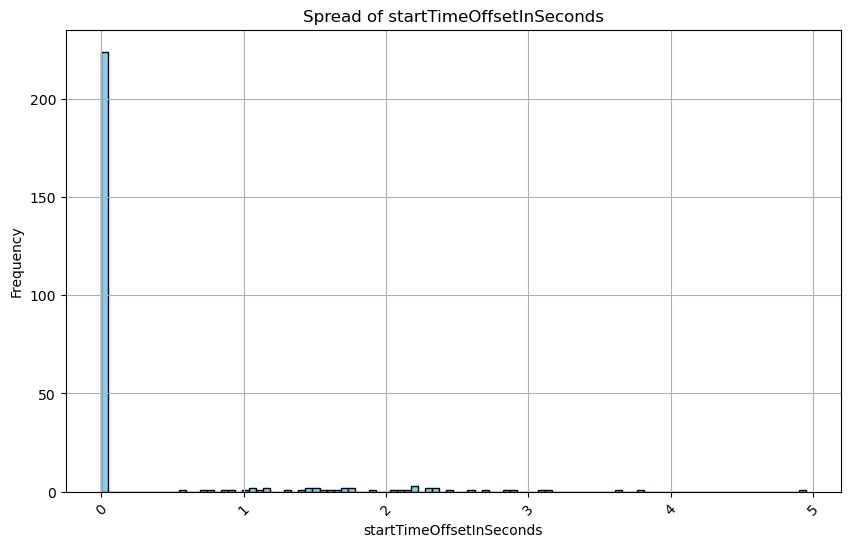

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(test_df['speed'], bins=100, color='skyblue', edgecolor='black')
plt.title('Spread of startTimeOffsetInSeconds')
plt.xlabel('startTimeOffsetInSeconds')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [43]:
test_df.columns

Index(['startTimeLocal', 'steps', 'userId', 'activeTimeInSeconds',
       'distanceInMeters', 'speed'],
      dtype='object')